In [11]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5, 6]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 1,
                 "param_name_str" : "t1t2",
                 "retrain_GP": 25,
                 "num_x_data": 5,
                 "outputscl": None,
                 "bo_iter_tot": 50,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]
# print(df.head())

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

#Get Mean Data from ep experiment
# df_mean = get_mean_data(df, name_cs_str, theta_true, job_list, date_time_str, save_csv)
# df_mean

#Get Median Data from ep experiment
# df_median = get_median_data(df, name_cs_str, theta_true, job_list, date_time_str, save_csv)
# df_median

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, name_cs_str, theta_true, job_list, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Regret,Speed,Time/Iter,EP Method Val,BO Method,Max Evals,Termination,Total Run Time,L2 Norm Theta
115,0,7,9.029953e-02,1.119565,0.000000e+00,[ 0.31578947 -0.52631579],6.610469e-02,1.354145e-02,[ 0.97157563 -1.01267467],1.354145e-02,[ 0.97157563 -1.01267467],0.001223,0.000194,2.354830,4,A1,23,ei-obj,54.161091,3.112221e-02
251,0,6,-2.964969e+00,0.500000,7.117797e-08,[ 1.57894737 -1.57894737],-3.298528e+00,-7.841074e+00,[ 1.00024226 -1.00339835],-7.841074e+00,[ 1.00024226 -1.00339835],0.918007,0.024172,3.573768,3,B1,22,ei-obj,78.622889,3.406979e-03
830,0,41,1.028611e-07,0.500000,1.367144e-74,[ 0.31578947 -0.52631579],9.422559e-08,7.301890e-08,[ 0.99992479 -1.000022 ],7.301890e-08,[ 0.99992479 -1.000022 ],0.000004,0.001994,15.472182,2,A2,43,obj,665.303838,7.835883e-05
1343,0,32,-1.814273e+01,0.500000,3.983316e+00,[ 0.99999159 -1.00000085],-1.720506e+01,-2.509471e+01,[ 0.99999952 -1.00000055],-2.509471e+01,[ 0.99999952 -1.00000055],62.088025,1.824560,247.752315,3,B2,50,max_budget,12387.615752,7.289640e-07
2211,1,16,8.056685e-05,0.840000,3.037351e-07,[ 0.86030407 -0.9106576 ],1.209920e-06,5.826286e-07,[ 0.99976836 -0.99996319],5.826286e-07,[ 0.99976836 -0.99996319],0.000015,0.000375,16.275899,2,C2,32,obj-regret,520.828758,2.345446e-04
2997,4,18,7.890437e-05,0.500000,2.744355e-07,[ 1.0966573 -0.99173343],3.318928e-06,1.335183e-07,[ 0.99999472 -0.9999374 ],1.335183e-07,[ 0.99999472 -0.9999374 ],0.000023,0.000167,17.272680,3,D2,34,obj-regret,587.271105,6.282283e-05


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn("ep_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

94b5a972b2876a71a8b281e9d1b4cd14
d897a5247c4fac3e8b6b98aacc96fa3c
9042ee735d9621b8ab4ba1d5118eb93c
307c9946b083fb235f83e5b21172b782
632761992bfc354d293060db11880958
887015c32ec382070b791a709356f7b6


In [5]:
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
# for i in range(len(job_list_best)): 
#     #define file path
#     file_path = "workspace/" + str(job_list_best[i].id) + "/BO_Results.gz"

#     #Open the file and get the dataframe
#     with gzip.open(file_path, 'rb') as fileObj:
#         results = pickle.load(fileObj)   
#     fileObj.close()

#     #Print ei results
#     print(results[run_num_list[i-1]].why_term)

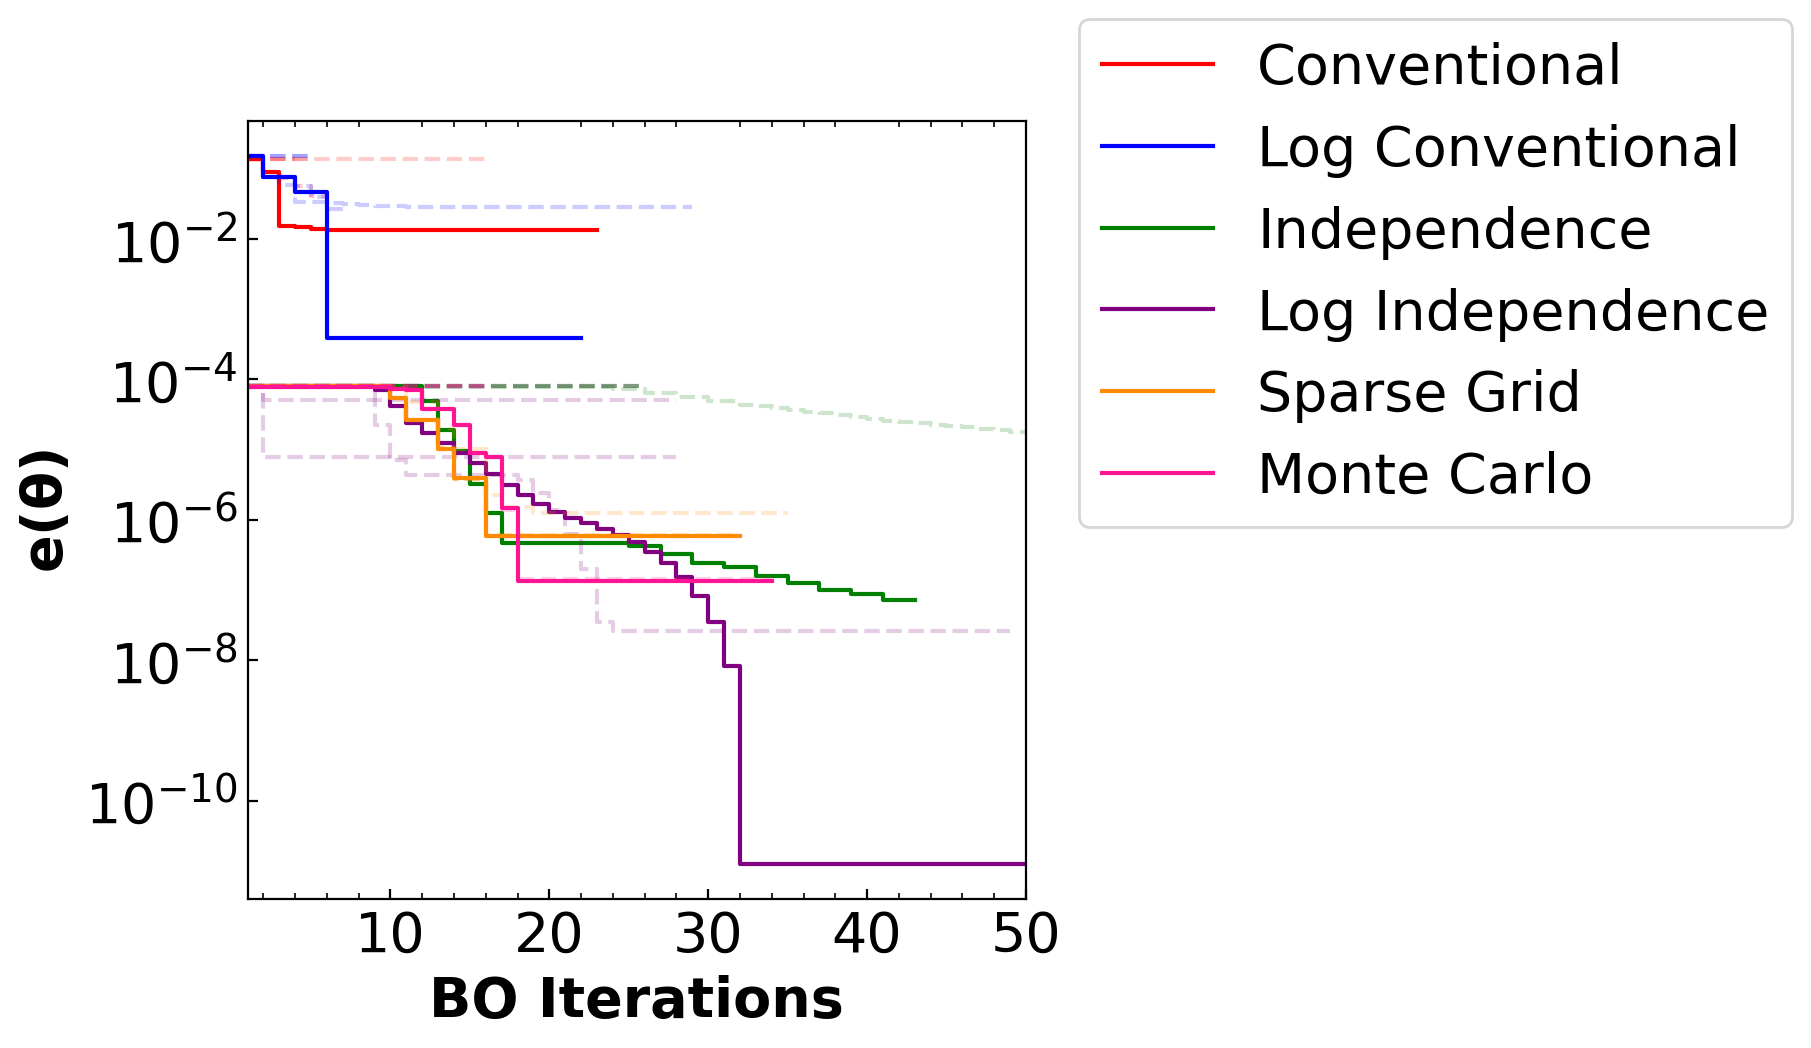

In [10]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2", "D2"]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["Min SSE"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["Max EI"]
# string_for_df_theta = ["Max EI"]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = r"$\mathbf{e(\theta)}$"
# y_label = "Max " + r"$\mathbf{EI(\theta)}$"
# title = "Min SSE Values"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_method_sse_one_plot(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [6]:
title_fontsize = 24
other_fontsize = 24
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
title = None
levels = [100,100,100, 100, 100, 100]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

meth_name_str_list = ["A1", "B1", "A2", "B2", "C2", "D2"]

pair = 0

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

compare_method_heat_maps(file_path_list, meth_name_str_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

/scratch365/mcarlozo/Toy_Problem/bo_methods_lib/bo_methods_lib/GPBO_Classes_plotters.py:1212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


KeyboardInterrupt: 

In [ ]:
#Make heat maps
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_fig = False
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best_path = job_list_best[0].fn("ep_study_best_all.csv")
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    get_ei = False
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
#     levels = [100,100,100, 100]
    z = [sse_sim, sse_mean]
    z_titles = ["ln(sse_sim)", "ln(sse)"]
    levels = [100,100]
#     z = [sse_mean]
#     z_titles = [meth_names[i] + " log("+ r"$\mathbf{e(\theta)}$" + ")"]
    
    
    save_path = job_list[i].fn("")
    
    if save_fig == False:
        save_path = None

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

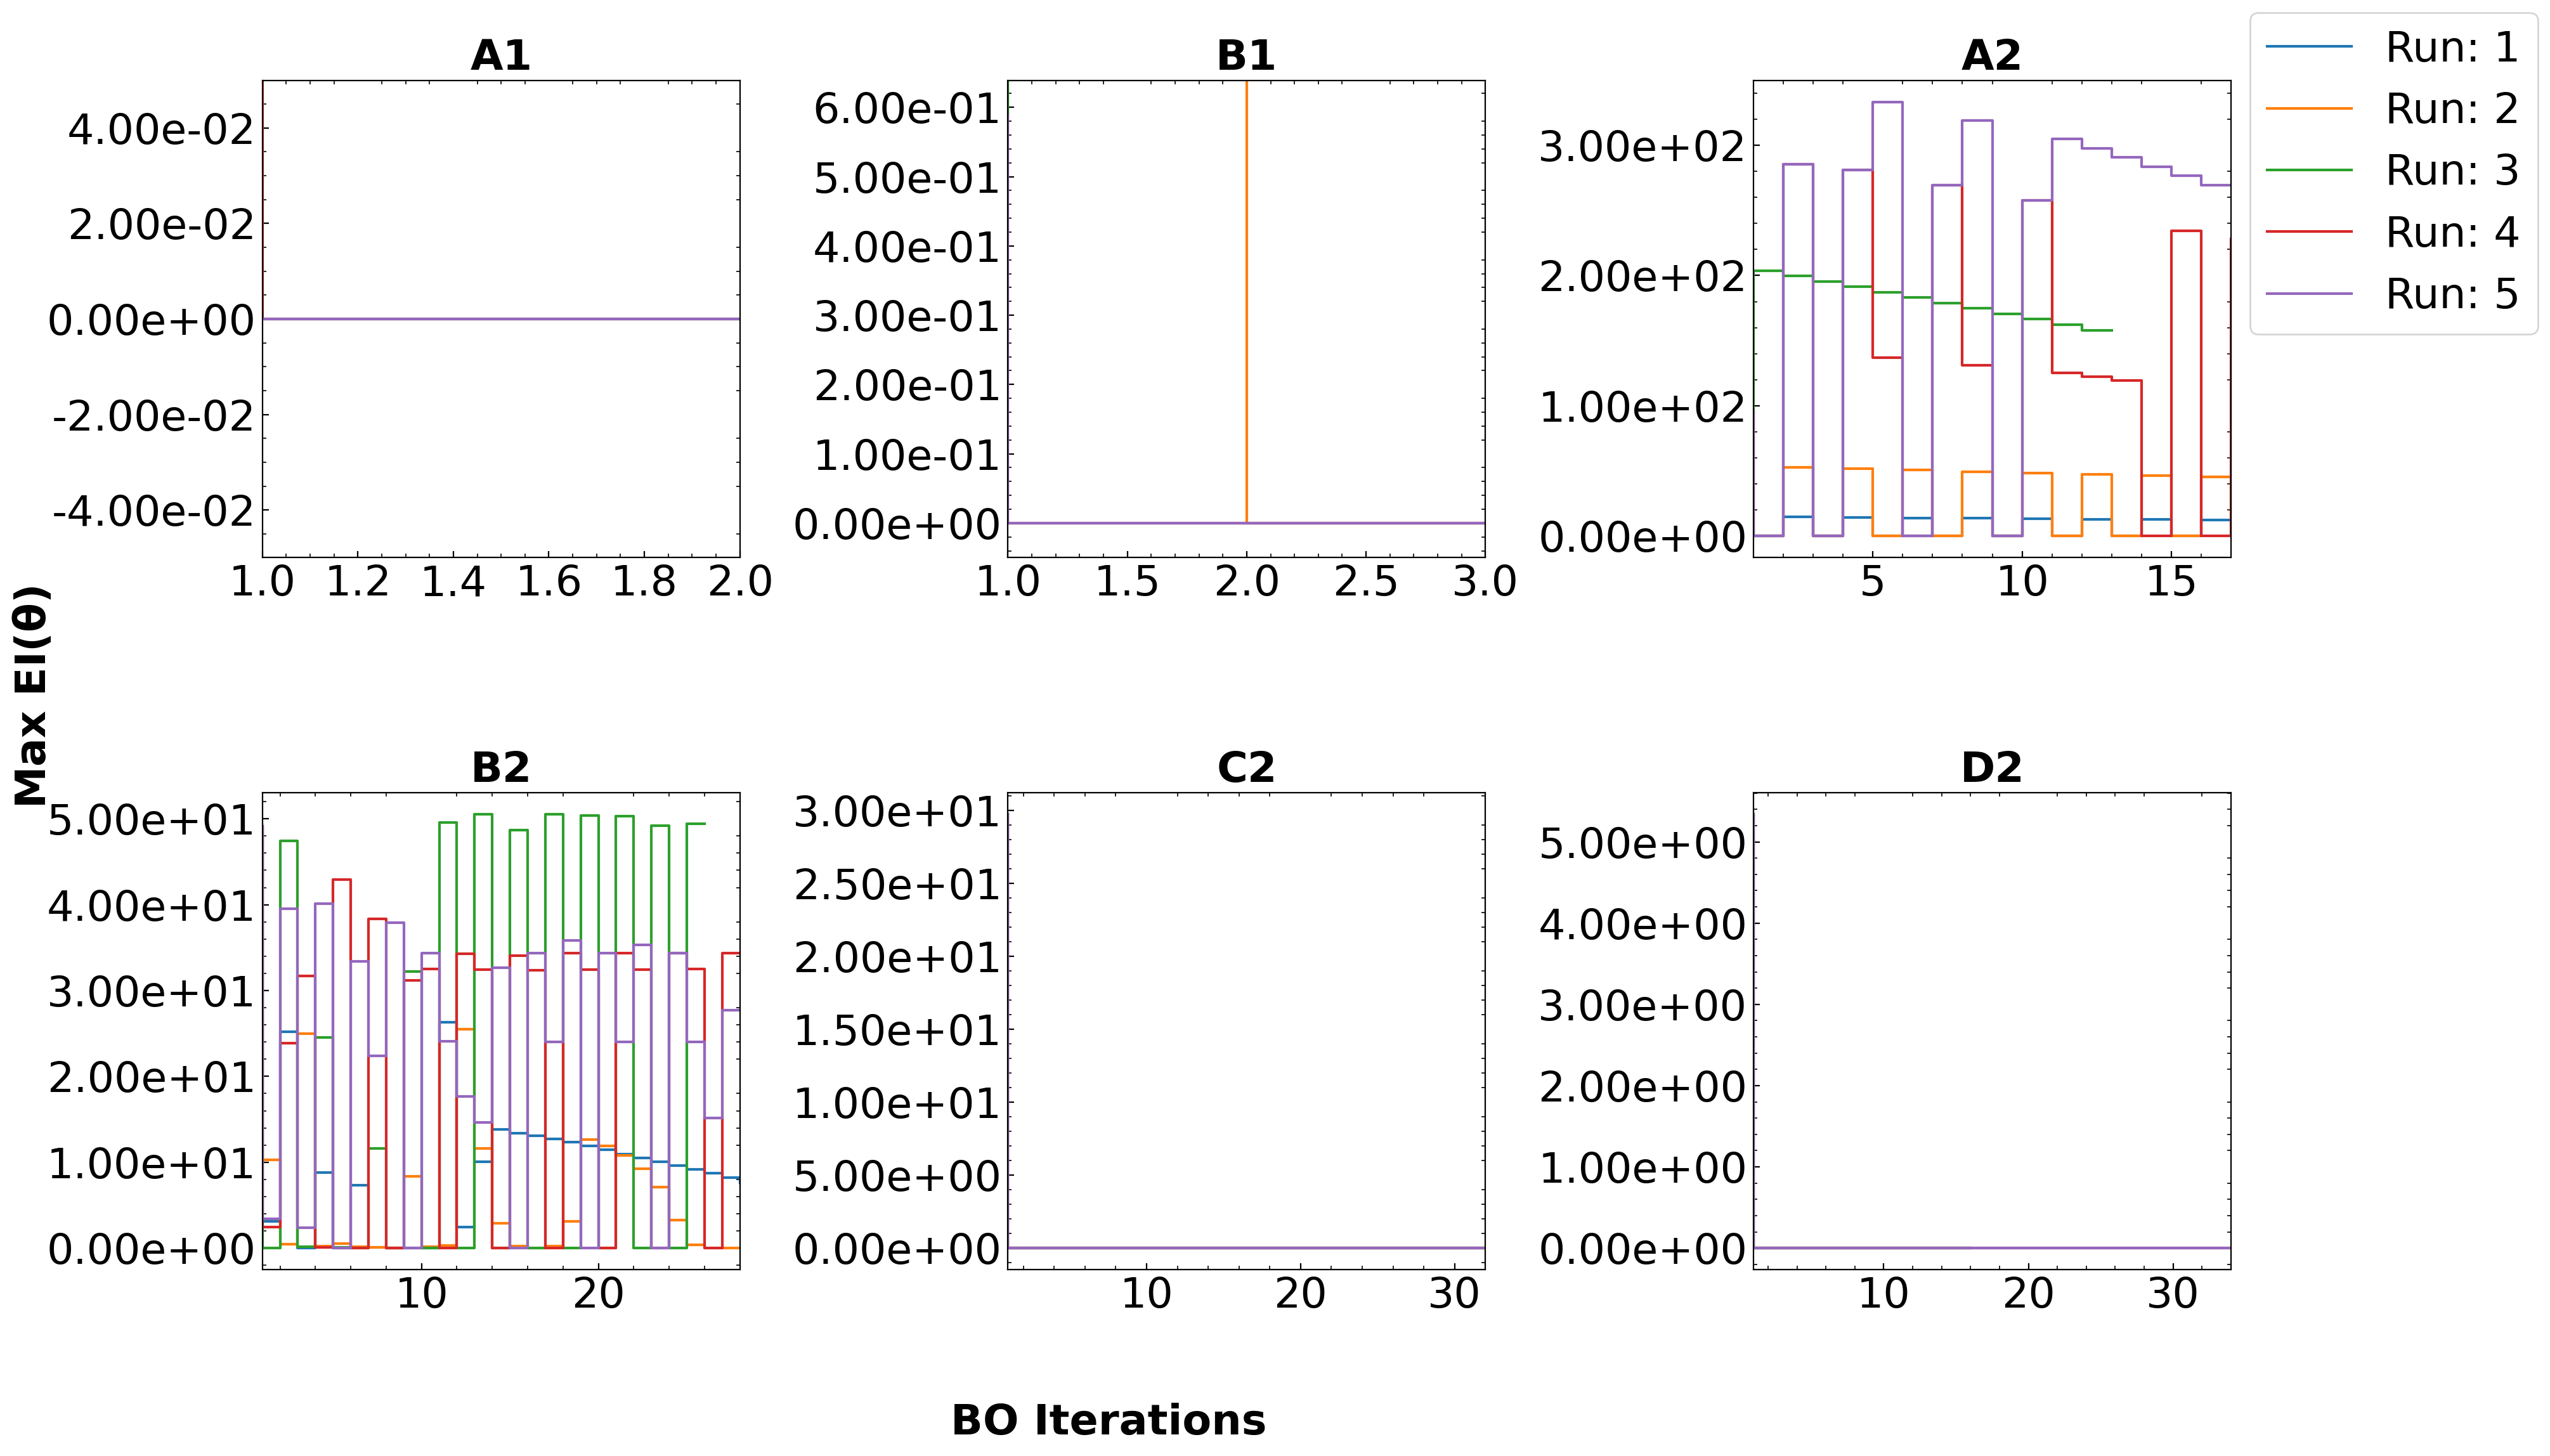

In [9]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2", "D2"]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
# data_names = ["Min SSE"]
# string_for_df_theta = ["Min Obj Cum."]
data_names = ["Max EI"]
string_for_df_theta = ["Max EI"]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 24
xbins = 5
ybins = 7
x_label = "BO Iterations"
# y_label = r"$\mathbf{e(\theta)}$"
y_label = "Max " + r"$\mathbf{EI(\theta)}$"
title = "Min SSE Values"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_compare_method_ei_sse(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get Best Data from sf experiment
save_csv = False
df_best = get_best_data(df, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

In [ ]:
# #Get Median Data from sf experiment
df_median = get_median_data(df, name_cs_str, theta_true, job_list,  date_time_str, save_csv)
df_median

In [ ]:
# #Get Median of Best Data from sf experiment
df_median_best = get_median_data(df_best, name_cs_str, theta_true, job_list,  date_time_str, save_csv)
df_median_best

In [ ]:
#Get HP Plots
#Set parameters
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Hyperparameters"
title = "Hyperparameter Values"
save_path = None
data_true = None
log_data = False

hps, hp_names, hp_true = analyze_hypers(file_path, run_num)
plot_2D_Data_w_BO_Iter(hps, hp_names, hp_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get sse, log_sse, and ei plots
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz" #CS1 A1 Best
# file_path = "workspace/b0e257d6e76025909e364903b3b792ee/BO_Results.gz" #CS1 B1 Best
# file_path = "workspace/d0c8b17229671998f3ffdab06c79e1f9/BO_Results.gz" #CS1 A2 Best
# file_path = "workspace/fdc2673ac83f3d0cf5b3b969a3e80825/BO_Results.gz" #CS1 B2 Best
# file_path = "workspace/9042085b58a00b76d6c2ae0a20cfe9f3/BO_Results.gz" #CS1 C2 Best
# file_path = date_time_str + "Data_Files/" + name_cs_str + "_BO_method_" + "C2" + "_sep_fact_0.9.gz"

loaded_results = open_file_helper(file_path)
meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name
run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
data_names = ["log(sse)"]
strings_for_df = ["Min Obj Cum."]
# data_names = ["log(sse)_{GP}", "log(sse)", "log(EI)"]
# strings_for_df = ["Min Obj", "Min Obj Cum.", "Max EI"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Data Values"
save_path = None
log_data = True

data, data_true = analyze_sse_min_sse_ei(file_path, run_num, strings_for_df)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ min sse
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values"
string_for_df_theta = "Theta Min Obj"
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, string_for_df_theta)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ min sse overall
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values Overall"
string_for_df_theta = "Theta Min Obj Cum."
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, string_for_df_theta)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ Max EI
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Max EI Parameter Values"
string_for_df_theta = "Theta Max EI"
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, string_for_df_theta)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Visualize training data
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1
bo_iter = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
zbins = 5
save_path = None

idcs_to_plot = [0,1,2]

title = "Data Run 1 BO Iter 1"
train_data, test_data, val_data, x_exp, data_names, data_true = analyze_train_test(file_path, run_num, bo_iter)

plot_train_test_val_data(train_data, test_data, None, data_names, idcs_to_plot, x_exp, xbins, ybins, zbins, 
                         title, title_fontsize, other_fontsize, save_path)

In [ ]:
#Plot xy data
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
# file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

run_num = 1
bo_iter = 1
x_lin_pts = 50

title_fontsize = 24
other_fontsize = 20
save_path = None

xbins = 5
ybins = 5
title = "CS1 Data Comparison"
x_label = "X Value"
y_label = "y Value"

theta_opt_data, exp_data, train_data, test_data = analyze_xy_plot(file_path, run_num, bo_iter, x_lin_pts)
plot_x_vs_y_given_theta(theta_opt_data, exp_data, train_data, test_data, xbins, ybins, title, x_label, y_label, 
                        title_fontsize, other_fontsize, save_path)

In [ ]:
#Param snesitivity analysis
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_0.1.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
# file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

run_num = 1
bo_iter = 1
n_points = 100
param_id = 0

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
save_path = None

list_of_data = analyze_param_sens(file_path, run_num, bo_iter, param_id, n_points)
param_data, param_idx, param_name, data_name, exp_data, train_data, test_data = list_of_data

title = "Param Sensitivity Analysis"
x_label = param_name
y_label = "Y Value"

data = [param_data]
data_names = [param_name]

plot_theta_vs_y_given_x(data, param_idx, data_names, exp_data, train_data, test_data, xbins, ybins, title, 
                        x_label, y_label, title_fontsize, other_fontsize, save_path)